In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os 
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import numpy as np

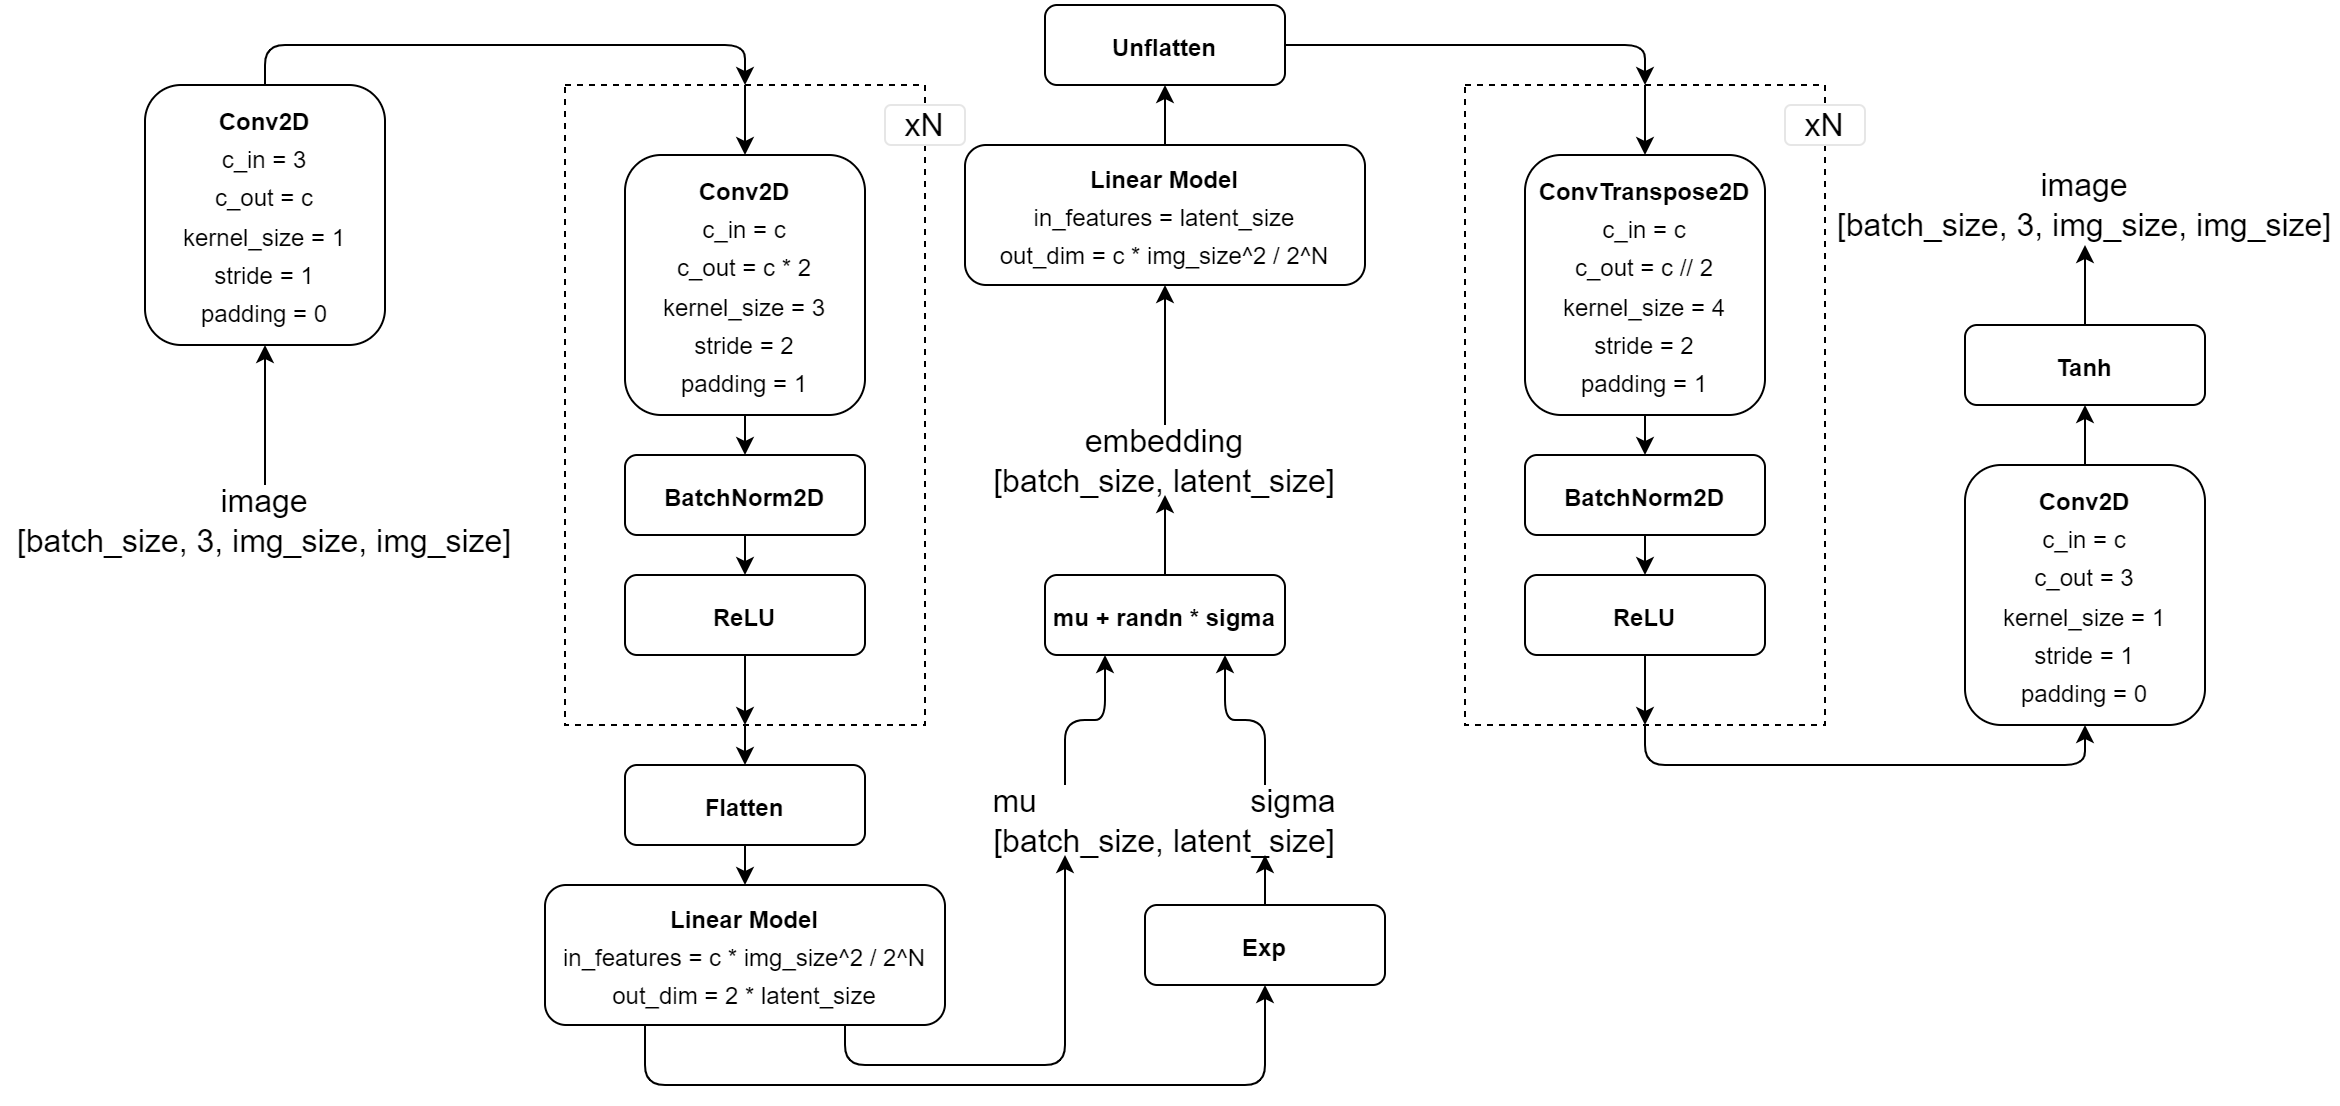

In [ ]:
def random_noise(batch_size, channels, side_size):
    return torch.randn(batch_size, channels, side_size, side_size).cuda()

def visualise(imgs, rows=2):
    imgs = (imgs.transpose(1, 3) + 1) / 2
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = (torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1]
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
class CatDataset(Dataset):
    def __init__(self, path_to_dataset="cat_136", size=64):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
        self.size = size
    
    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path) # 136 x 136
        crop_rate = 8
        x_crop = random.randint(0, crop_rate)
        y_crop = random.randint(0, crop_rate)
        img = img[x_crop:136 - crop_rate + x_crop, y_crop:136 - crop_rate + y_crop]
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        return 2 * torch.tensor(img).float().transpose(0, 2) / 255. - 1
    
    def __len__(self):
        return len(self.photo_names)
    
dataset = CatDataset()
visualise(torch.cat([dataset[i].unsqueeze(0) for i in [3, 15, 182, 592, 394, 2941]], dim=0))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, img_size=128, latent_size=512, start_channels=16, downsamplings=5):
        super(Encoder, self).__init__()
        
        self.latent_size = latent_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=start_channels, kernel_size=1, stride=1, padding=0),
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels=(2**i)*start_channels,out_channels=(2**(i+1))*start_channels, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d((2**(i+1)) * start_channels),
                    nn.ReLU()
                ) 
                for i in range(downsamplings)
            ], 
            nn.Flatten(),
            nn.Linear(start_channels * img_size**2 // 2**(downsamplings), 2 * latent_size)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        mu, sigma = torch.split(x, self.latent_size, dim=1)
        sigma = torch.exp(sigma)
        eps = torch.randn(mu.size(0), mu.size(1)).to(mu.get_device())
        z = mu + sigma * eps
        return z, (mu, sigma)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, img_size=128, latent_size=512, end_channels=16, upsamplings=5):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, end_channels * img_size**2 // 2**(upsamplings)),
            nn.Unflatten(dim = 1, unflattened_size = (end_channels * (2**upsamplings), img_size // (2**upsamplings), img_size // (2**upsamplings))),
            nn.Sequential(
                *[
                    nn.Sequential(
                        nn.ConvTranspose2d(in_channels=(2**i)*end_channels, out_channels=(2**(i-1))*end_channels, kernel_size=4, stride=2, padding=1),
                        nn.BatchNorm2d((2**(i-1))*end_channels),
                        nn.ReLU()
                    )
                    for i in range(upsamplings, 0, -1)
                ],
            ),
            nn.Conv2d(end_channels, 3, kernel_size = 1, stride = 1, padding = 0),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.decoder(z)

In [ ]:
class VAE(nn.Module):
    def __init__(self, img_size=128, downsamplings=5, latent_size=256, down_channels=8, up_channels=12):
        super(VAE, self).__init__()
        self.encoder = Encoder(img_size, latent_size, down_channels, downsamplings)
        self.decoder = Decoder(img_size, latent_size, up_channels, downsamplings)
        self.latent_size = latent_size
        
    def forward(self, x):
        z, (mu, sigma) = self.encoder(x)
        x_pred = self.decoder(z)
        kld = 0.5 * (sigma + torch.square(mu) - torch.log(sigma) - torch.ones(self.latent_size).cuda())
        return x_pred, kld
    
    def encode(self, x):
        z, (mu, sigma) = self.encoder(x)
        return z
    
    def decode(self, z):
        return self.decoder(z)
    
    def save(self):
        torch.save(self.state_dict(), __file__[:-7] + 'checkpoint.pth')
    
    def load(self):
        self.load_state_dict(torch.load(__file__[:-7] + 'checkpoint.pth'))
        self.eval()

In [ ]:
def train_vae():
    vae = VAE()
    vae.cuda()

    epochs = 201
    batch_size = 8
    vae_optim = Adam(vae.parameters(), lr=1e-4)

    dataset = CatDataset(size=128)

    test_imgs_1 = torch.cat([dataset[i].unsqueeze(0) for i in (0, 34, 76, 1509)])
    test_imgs_2 = torch.cat([dataset[i].unsqueeze(0) for i in (734, 123, 512, 3634)])

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
        total_batches = 0
        rec_loss_avg = 0
        kld_loss_avg = 0

        if ep % 10 == 0:
            with torch.no_grad():
                z_1 = vae.encode(test_imgs_1.cuda())
                z_2 = vae.encode(test_imgs_2.cuda())
                x_int = []
                for i in range(9):
                    z = (i * z_1 + (8 - i) * z_2) / 8
                    x_int.append(vae.decode(z))
                x_int = torch.cat(x_int)
                visualise(x_int, rows=len(test_imgs_1))
                z_rand = torch.randn_like(z_1)
                x_int = vae.decode(z_rand)
                visualise(x_int, rows=len(test_imgs_1)//2)

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            x = batch.cuda()
            x_rec, kld = vae(x)
            img_elems = float(np.prod(list(batch.size())))
            kld_loss = kld.sum() / batch_size
            rec_loss = ((x_rec - x)**2).sum() / batch_size
            loss = rec_loss + 0.1 * kld_loss # https://openreview.net/forum?id=Sy2fzU9gl
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            kld_loss_avg += kld_loss.item()
            rec_loss_avg += rec_loss.item()

        print(f"Epoch {ep+1} | Reconstruction loss: {rec_loss_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")

train_vae()